In [1]:
from h5rdmtoolbox.h5wrapper import H5Flow

# Create two flow types (Poiseuille and rankine vortex)

In [2]:
from h5rdmtoolbox import tutorial

In [3]:
vel_couette = tutorial.get_xr_dataset('couette2d')

The above variables are of type `xarray.Dataset`:

In [4]:
vel_couette

<xarray.Dataset>
Dimensions:  (y: 10, x: 2)
Coordinates:
  * x        (x) float64 0.0 4.0
  * y        (y) float64 0.0 0.4444 0.8889 1.333 1.778 ... 2.667 3.111 3.556 4.0
Data variables:
    u        (y, x) float64 0.0 0.0 0.2222 0.2222 0.4444 ... 1.778 1.778 2.0 2.0
    v        (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    w        (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    mag      (y, x) float64 0.0 0.0 0.2222 0.2222 0.4444 ... 1.778 1.778 2.0 2.0
Attributes:
    long_name:  velocity data

The velocity component can directly be plotted with coorect units at the labels:

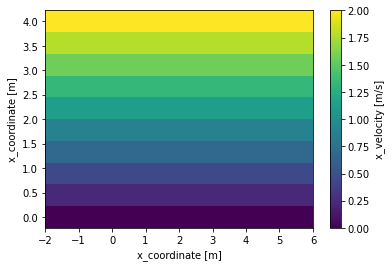

In [5]:
vel_couette.u.plot()

# Add both flow types to individual groups

A `xarray.Dataset` can be stored in an HDF file as done in the following:

In [6]:
vel_poiseuille = tutorial.get_xr_dataset('poiseuille2D')
vel_poiseuille

<xarray.Dataset>
Dimensions:  (y: 10, x: 2)
Coordinates:
  * x        (x) float64 0.0 4.0
  * y        (y) float64 0.0 0.4444 0.8889 1.333 1.778 ... 2.667 3.111 3.556 4.0
Data variables:
    u        (y, x) float64 0.0 0.0 0.7901 0.7901 ... 0.7901 0.7901 0.0 0.0
    v        (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    w        (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    mag      (y, x) float64 0.0 0.0 0.7901 0.7901 ... 0.7901 0.7901 0.0 0.0
Attributes:
    long_name:  velocity data

In [7]:
with H5Flow(mode='w') as h5:
    h5.create_dataset('vel', data=[1,2,3], standard_name='x_velocity', units='m/s')
    print(type(h5.vel.standard_name))

<class 'h5rdmtoolbox.conventions.standard_names.StandardName'>


<HDF5 dataset "u": shape (10, 2), type "<f8">


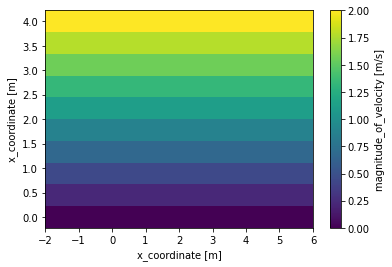

In [8]:
with H5Flow(mode='w') as h5:
    grp1 = h5.create_group('couette', long_name='couette group')
    grp1.create_dataset_from_xarray_dataset(vel_couette)    
    
    grp2 = h5.create_group('poiseuille', long_name='poiseuille group')
    grp2.create_dataset_from_xarray_dataset(vel_poiseuille)
    hdf_filename = h5.hdf_filename
    
    u = h5.couette.u[:]
    h5.couette.mag[:].plot()
    print(h5.couette.u.__repr__())
    
    h5.dump()

A `xarray.Dataset` can be created from the hdf file to get the velocity components within one dataset:

In [9]:
with H5Flow(hdf_filename, mode='r') as h5:
    h5.dump()
    vel = h5.couette.get_vector('x_velocity', 'y_velocity')[:, :]

In [10]:
vel

<xarray.Dataset>
Dimensions:  (y: 10, x: 2)
Coordinates:
  * y        (y) float64 0.0 0.4444 0.8889 1.333 1.778 ... 2.667 3.111 3.556 4.0
  * x        (x) float64 0.0 4.0
Data variables:
    u        (y, x) float64 0.0 0.0 0.2222 0.2222 0.4444 ... 1.778 1.778 2.0 2.0
    v        (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Attributes:
    units:      m/s
    long_name:  vector data

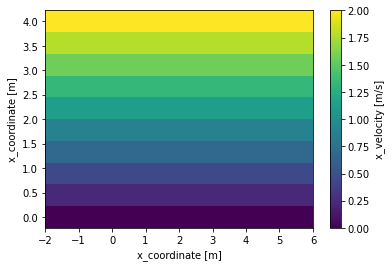

In [11]:
vel.u.plot()

In [12]:
u = vel.u[0,:]

In [13]:
u.coords['y'].attrs.get('standard_name')

'x_coordinate'